In [391]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
#from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [392]:
country_to_predict="Brazil"

**ARIMA**


In [393]:
df=pd.read_excel('test_arima.xlsx')
df['Year']=pd.to_datetime(df.Year, format="%Y")
df=df[(df['Country']==country_to_predict)]
df.index.freq = 'YS'
df.head()

,Year,Value,Country
49,1970-01-01,58.911,Brazil
50,1971-01-01,59.332,Brazil
51,1972-01-01,59.739,Brazil
52,1973-01-01,60.132,Brazil
53,1974-01-01,60.513,Brazil


In [394]:
del df["Country"]

In [395]:
df['Year']=pd.to_datetime(df['Year'], format="%Y")
df=df.set_index(['Year'])
df.head()
df.index.freq = 'YS'

In [396]:
train_df = df[:len(df)-6]
test_df = df[len(df)-6:]

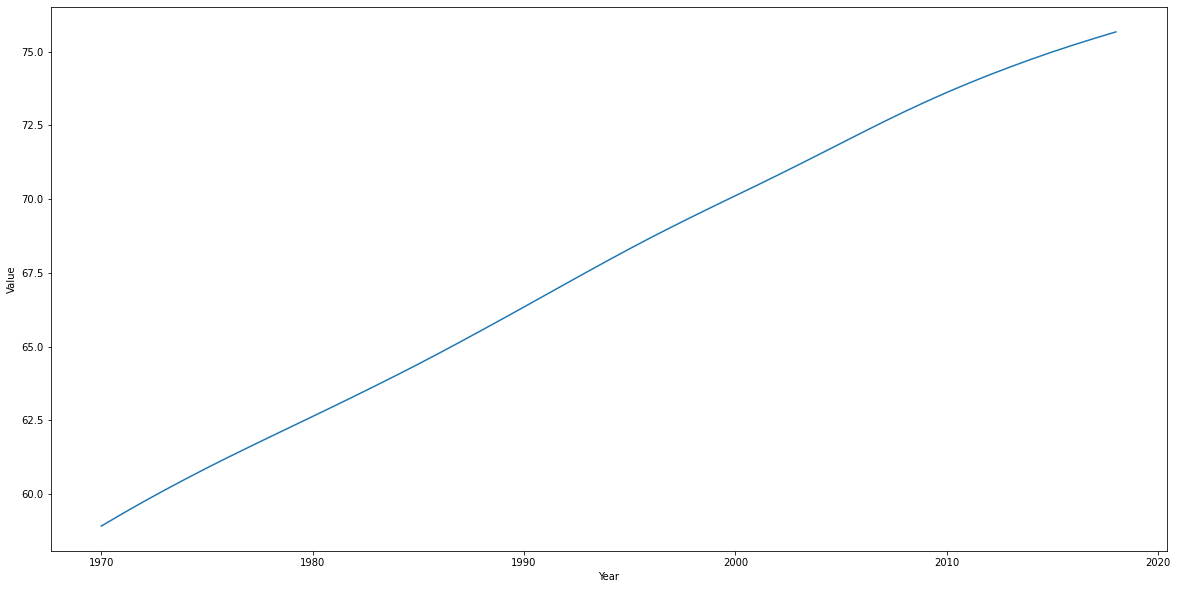

In [397]:
plt.figure(figsize=(20,10))
plt.xlabel("Year")
plt.ylabel("Value")
plt.plot(df)

In [398]:
rolmean=train_df.rolling(window=6).mean()
rolstd=train_df.rolling(window=6).std()
print(rolmean.head(15))
print(rolstd.head(15))

                Value
Year                 
1970-01-01        NaN
1971-01-01        NaN
1972-01-01        NaN
1973-01-01        NaN
1974-01-01        NaN
1975-01-01  59.918500
1976-01-01  60.307167
1977-01-01  60.684333
1978-01-01  61.051500
1979-01-01  61.410500
1980-01-01  61.763333
1981-01-01  62.112000
1982-01-01  62.459167
1983-01-01  62.806667
1984-01-01  63.156167
               Value
Year                
1970-01-01       NaN
1971-01-01       NaN
1972-01-01       NaN
1973-01-01       NaN
1974-01-01       NaN
1975-01-01  0.737897
1976-01-01  0.714889
1977-01-01  0.694172
1978-01-01  0.676546
1979-01-01  0.662389
1980-01-01  0.652460
1981-01-01  0.647525
1982-01-01  0.646828
1983-01-01  0.649776
1984-01-01  0.655613


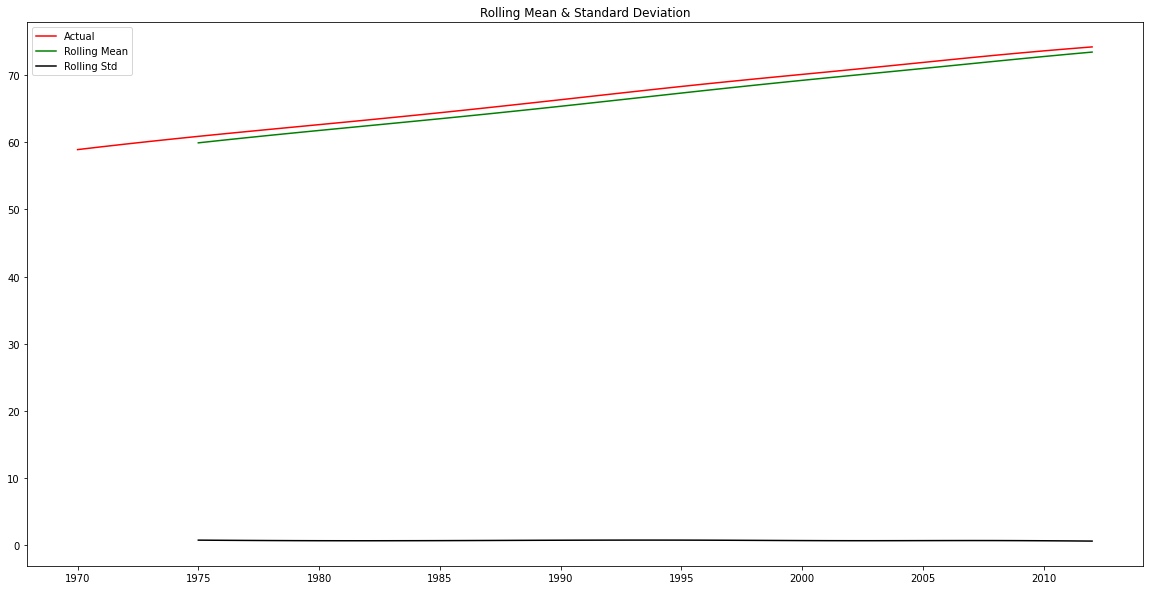

In [399]:
plt.figure(figsize=(20,10))
actual=plt.plot(train_df, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [400]:
from statsmodels.tsa.stattools import adfuller
print('Dickey-Fuller Test: ')
dftest=adfuller(train_df['Value'], autolag='AIC')
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Dickey-Fuller Test: 
Test Statistic          -1.474066
p-value                  0.546299
Lags Used                4.000000
No. of Obs              38.000000
Critical Value (1%)     -3.615509
Critical Value (5%)     -2.941262
Critical Value (10%)    -2.609200
dtype: float64


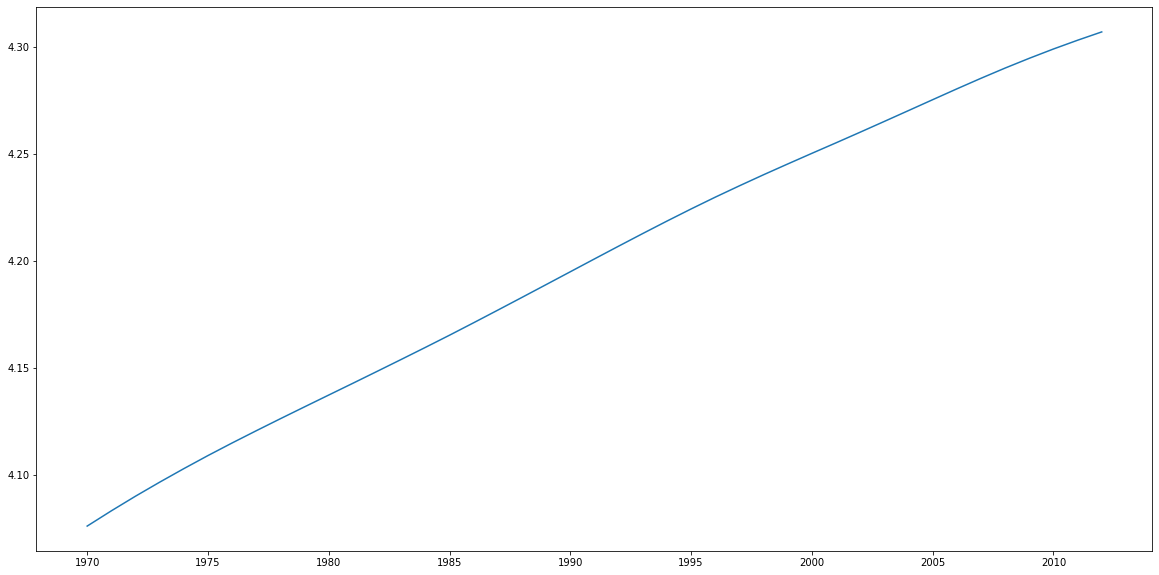

In [401]:
plt.figure(figsize=(20,10))
df_log=np.log(train_df)
plt.plot(df_log)

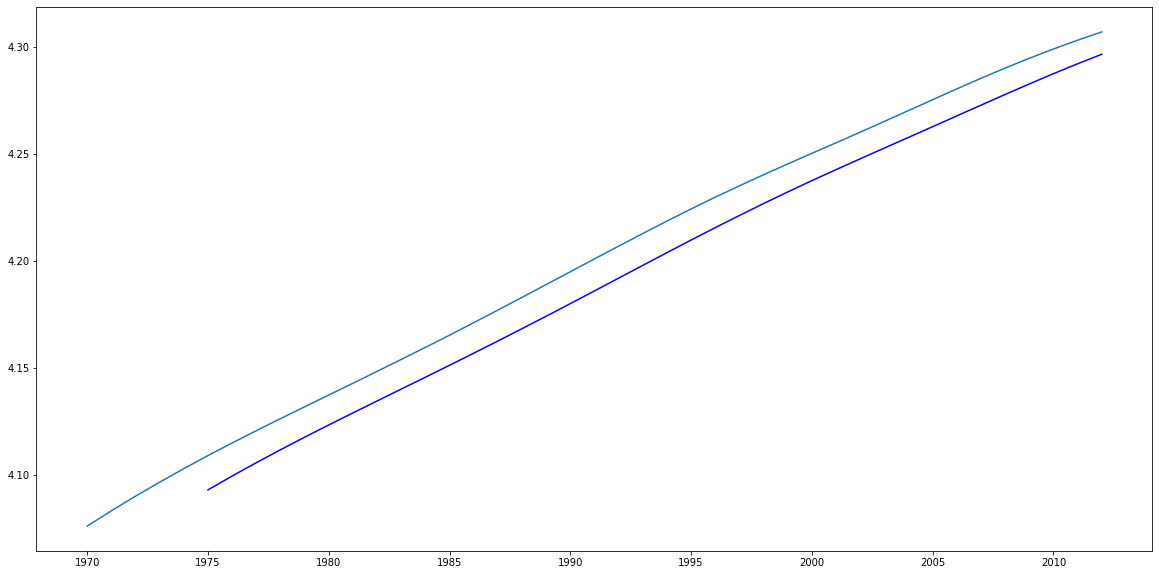

In [402]:
plt.figure(figsize=(20,10))
MAvg=df_log.rolling(window=6).mean()
MStd=df_log.rolling(window=6).std()
plt.plot(df_log)
plt.plot(MAvg, color='blue')

In [403]:
df_log_diff=df_log-MAvg
df_log_diff.head(12)

,Value
Year,
1970-01-01,NaN
1971-01-01,NaN
1972-01-01,NaN
1973-01-01,NaN
1974-01-01,NaN
1975-01-01,0.016048
1976-01-01,0.015457
1977-01-01,0.014950
1978-01-01,0.014532


In [404]:
df_log_diff=df_log_diff.dropna()
df_log_diff.head()

,Value
Year,
1975-01-01,0.016048
1976-01-01,0.015457
1977-01-01,0.014950
1978-01-01,0.014532
1979-01-01,0.014204


In [405]:
def stationarity(timeseries):
    
    rolmean=timeseries.rolling(window=6).mean()
    rolstd=timeseries.rolling(window=6).std()
    
    plt.figure(figsize=(20,10))
    actual=plt.plot(timeseries, color='red', label='Actual')
    mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
    std_6=plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Dickey-Fuller Test: ')
    dftest=adfuller(timeseries['Value'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

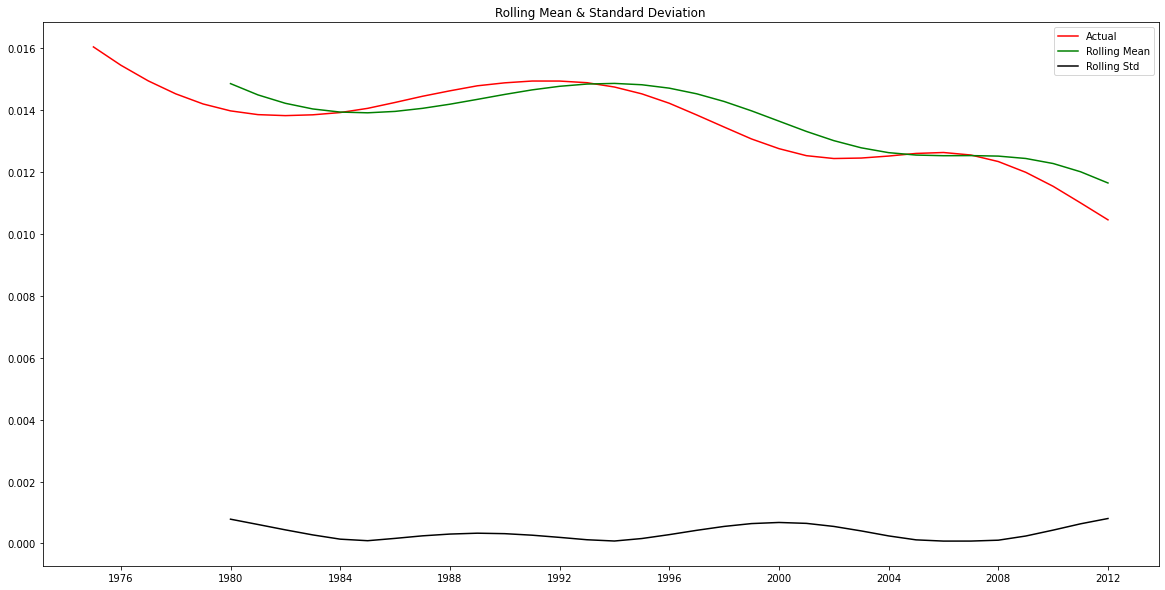

Dickey-Fuller Test: 
Test Statistic           2.188272
p-value                  0.998873
Lags Used                8.000000
No. of Obs              29.000000
Critical Value (1%)     -3.679060
Critical Value (5%)     -2.967882
Critical Value (10%)    -2.623158
dtype: float64


In [406]:
stationarity(df_log_diff)

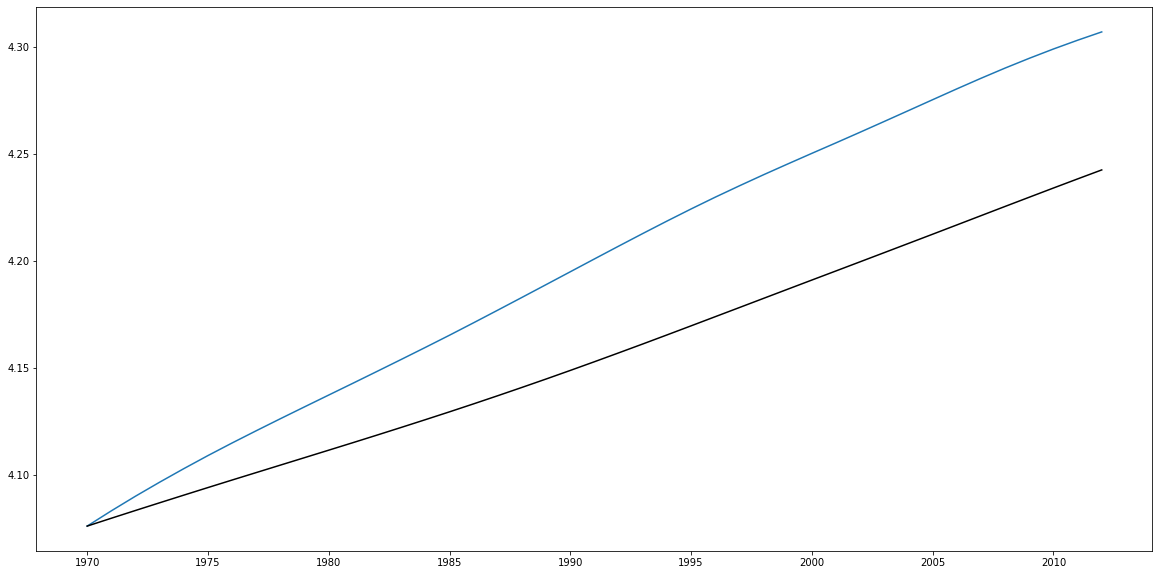

In [407]:
plt.figure(figsize=(20,10))
exp_df=df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(df_log)
plt.plot(exp_df, color='black')

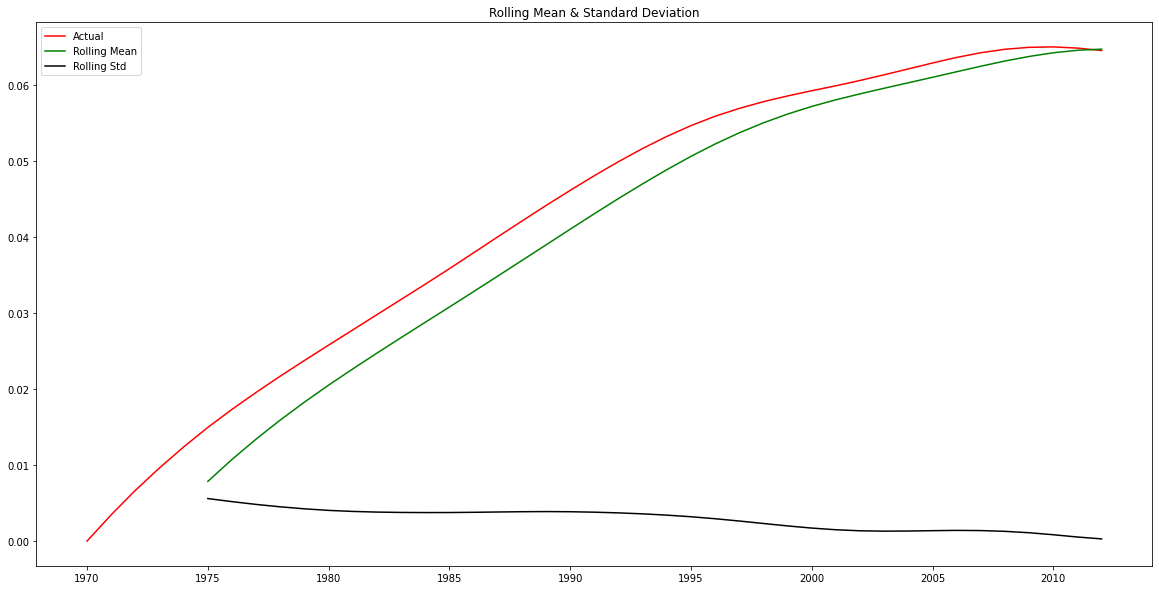

Dickey-Fuller Test: 
Test Statistic          -0.623477
p-value                  0.865588
Lags Used                5.000000
No. of Obs              37.000000
Critical Value (1%)     -3.620918
Critical Value (5%)     -2.943539
Critical Value (10%)    -2.610400
dtype: float64


In [408]:
exp_df_diff=df_log-exp_df
stationarity(exp_df_diff)

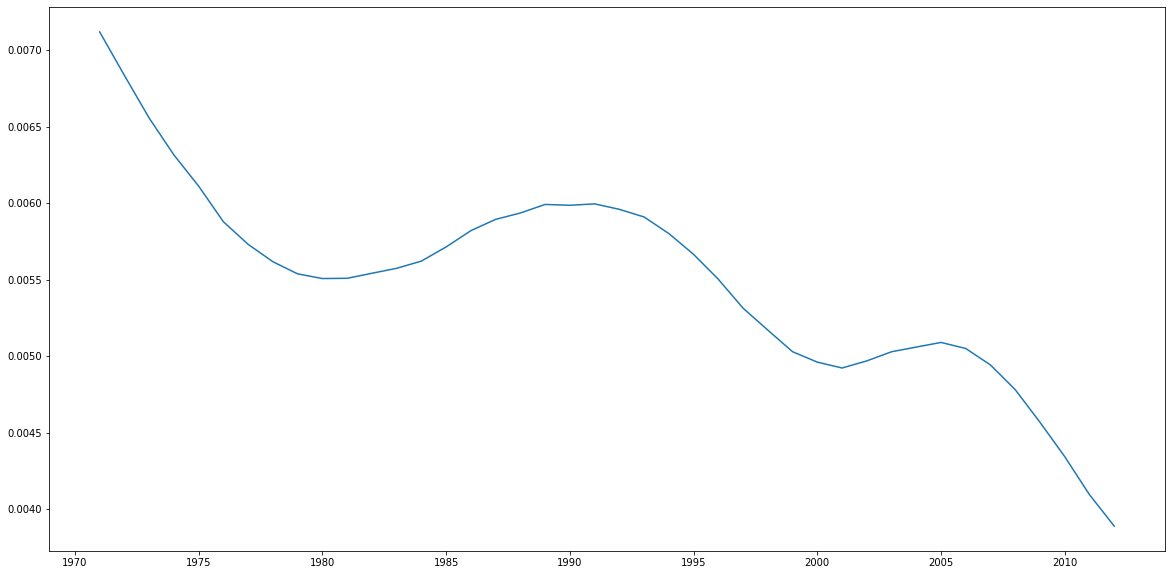

In [409]:
plt.figure(figsize=(20,10))
df_shift=df_log-df_log.shift()
plt.plot(df_shift)

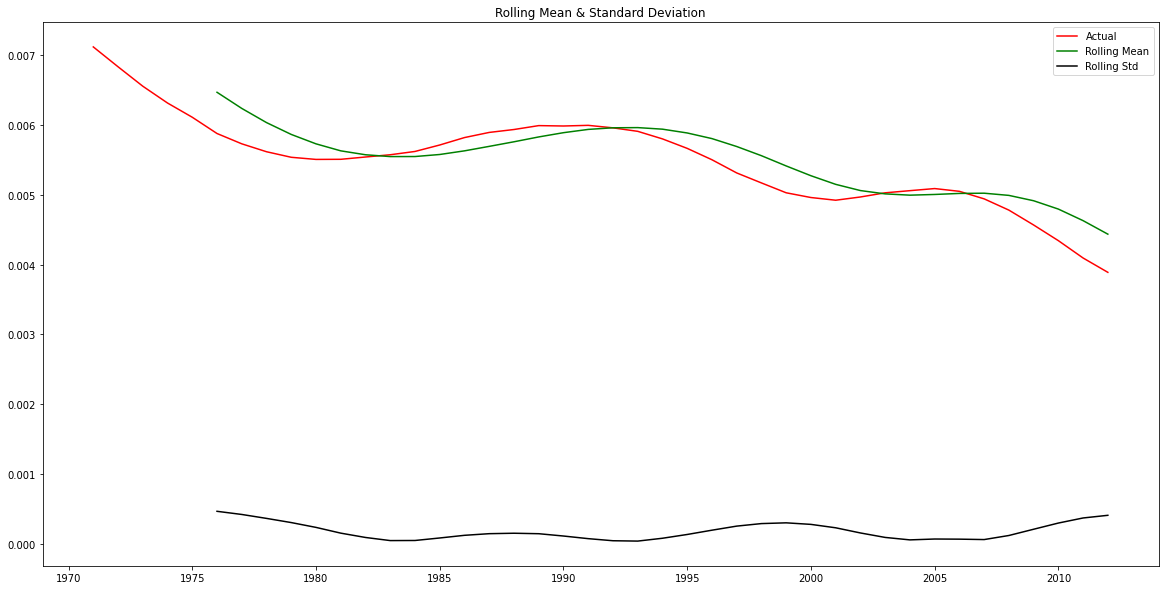

Dickey-Fuller Test: 
Test Statistic          -0.200954
p-value                  0.938408
Lags Used                3.000000
No. of Obs              38.000000
Critical Value (1%)     -3.615509
Critical Value (5%)     -2.941262
Critical Value (10%)    -2.609200
dtype: float64


In [410]:
df_shift=df_shift.dropna()
stationarity(df_shift)

Text(0.5, 1.0, 'Partial Autocorrelation Function')

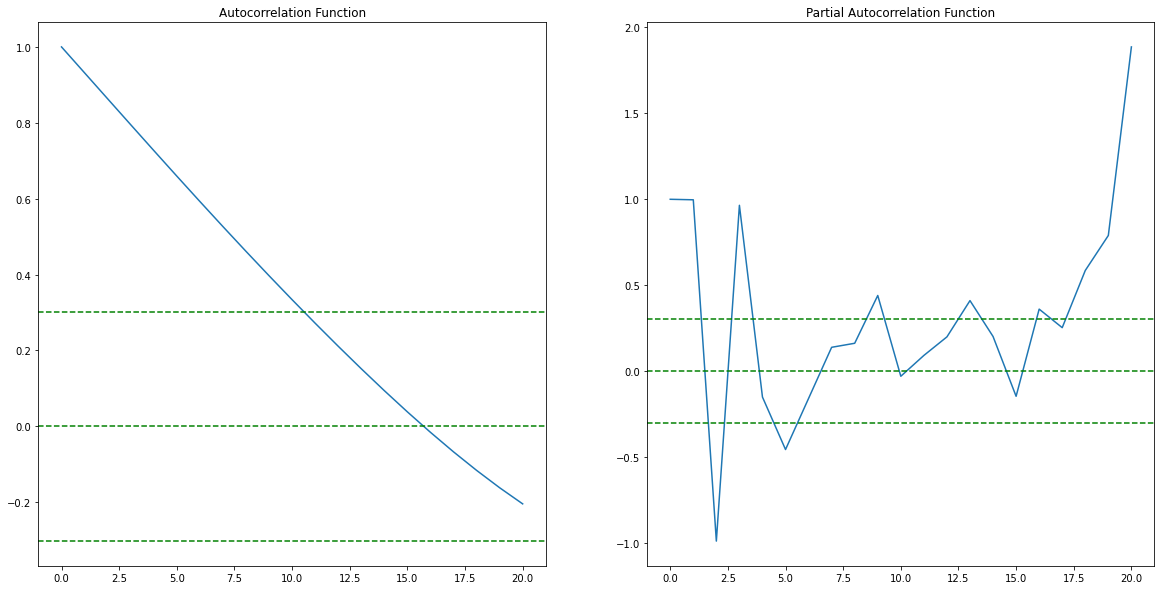

In [411]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf=acf(train_df, nlags=20)
lag_pacf=pacf(train_df, nlags=20, method='ols')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.title('Partial Autocorrelation Function')

plotting ARIMA model


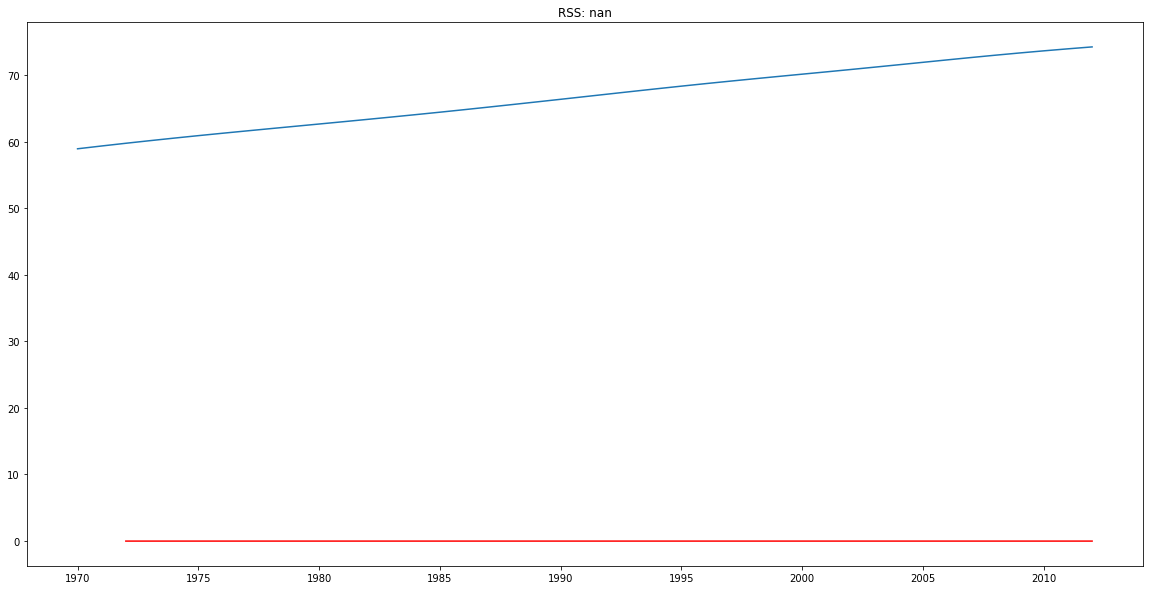

In [446]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(20,10))
model=ARIMA(df_log, order=(1,2,2))
results=model.fit(disp=-1)
plt.plot(train_df)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-df_shift['Value'])**2))
print('plotting ARIMA model')

In [447]:
predictions=pd.Series(results.fittedvalues, copy=True)
print(predictions.head())

Year
1972-01-01   -0.000134
1973-01-01   -0.000278
1974-01-01   -0.000271
1975-01-01   -0.000227
1976-01-01   -0.000182
Freq: AS-JAN, dtype: float64


In [448]:
predictions_cum_sum=predictions.cumsum()
print(predictions_cum_sum.head())

Year
1972-01-01   -0.000134
1973-01-01   -0.000411
1974-01-01   -0.000682
1975-01-01   -0.000909
1976-01-01   -0.001092
Freq: AS-JAN, dtype: float64


In [449]:
predictions_log=pd.Series(df_log['Value'].iloc[0], index=df_log.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
#predictions_log.head()

In [450]:
arima_pred = results.predict(start = len(train_df), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred=np.exp(arima_pred)
test_df['ARIMA_Predictions'] = arima_pred
#arima_pred


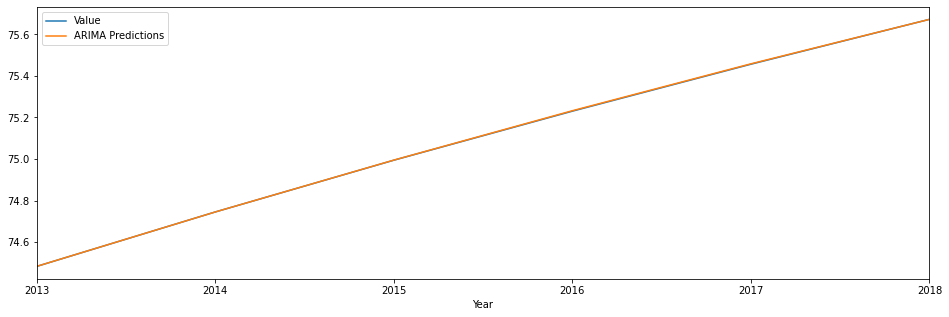

In [451]:
test_df['Value'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [452]:
arima_rmse_error = rmse(test_df['Value'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 1.4324573980765943e-06
RMSE Error: 0.001196853123017438
Mean: 67.74491836734695


In [453]:
output=results.forecast(13)
output1=np.exp(output[0])
output1
outputs = pd.DataFrame(output1[-7:])
outputs.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
outputs["Country"]=country_to_predict
outputs

,0,Country
2019,75.874244,Brazil
2020,76.065085,Brazil
2021,76.244493,Brazil
2022,76.412547,Brazil
2023,76.569319,Brazil
2024,76.714871,Brazil
2025,76.849260,Brazil


In [454]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_arima.xlsx')
writer = pandas.ExcelWriter('test_arima.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    outputs.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

In [455]:
test_df

,Value,ARIMA_Predictions
Year,,
2013-01-01,74.483,74.483156
2014-01-01,74.745,74.744948
2015-01-01,74.994,74.994562
2016-01-01,75.230,75.232160
2017-01-01,75.456,75.457890
2018-01-01,75.672,75.671879


**LSTM**

In [533]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [534]:
df=pd.read_excel('test_lstm.xlsx')
df['Year']=pd.to_datetime(df.Year, format="%Y")
df=df[(df['Country']==country_to_predict)]
del df["Country"]
df['Year']=pd.to_datetime(df['Year'], format="%Y")
df=df.set_index(['Year'])
df.index.freq = 'YS'
train_df_lstm = df[:len(df)-6]
test_df_lstm = df[len(df)-6:]
df.tail()

,Value
Year,
2014-01-01,74.745
2015-01-01,74.994
2016-01-01,75.230
2017-01-01,75.456
2018-01-01,75.672


In [535]:
scaler.fit(train_df)
scaled_train_data = scaler.transform(train_df_lstm)
scaled_test_data = scaler.transform(test_df_lstm)

In [536]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [537]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [538]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
31/31 [==============================] - 0s 5ms/step - loss: 0.2034
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.0058
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 6.8093e-04
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 4.8616e-04
Epoch 5/20
31/31 [==============================] - 0s 6ms/step - loss: 4.6903e-04
Epoch 6/20
31/31 [==============================] - 0s 5ms/step - loss: 5.7438e-04
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 5.1204e-04
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 5.8200e-04
Epoch 9/20
31/31 [==============================] - 0s 5ms/step - loss: 5.3292e-04
Epoch 10/20
31/31 [==============================] - 0s 5ms/step - loss: 6.7255e-04
Epoch 11/20
31/31 [==============================] - 0s 5ms/step - loss: 3.4128e-04
Epoch 12/20
31/31 [==============================] - 0s 6ms/step - loss: 2.0122e-04
Epoch 13/

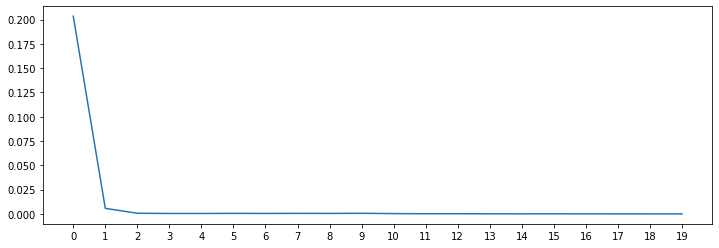

In [539]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [540]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_df)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [541]:
lstm_predictions_scaled

[array([1.0376476], dtype=float32),
 array([1.0632296], dtype=float32),
 array([1.0894297], dtype=float32),
 array([1.1162608], dtype=float32),
 array([1.1437835], dtype=float32),
 array([1.1720709], dtype=float32)]

In [542]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [543]:
lstm_predictions

array([[74.78493306],
       [75.17628582],
       [75.5770961 ],
       [75.98755721],
       [76.40859922],
       [76.84134003]])

In [544]:
test_df['LSTM_Predictions'] = lstm_predictions

In [545]:
test_df

,Value,ARIMA_Predictions,LSTM_Predictions
Year,,,
2013-01-01,74.483,74.483156,74.784933
2014-01-01,74.745,74.744948,75.176286
2015-01-01,74.994,74.994562,75.577096
2016-01-01,75.230,75.232160,75.987557
2017-01-01,75.456,75.457890,76.408599
2018-01-01,75.672,75.671879,76.841340


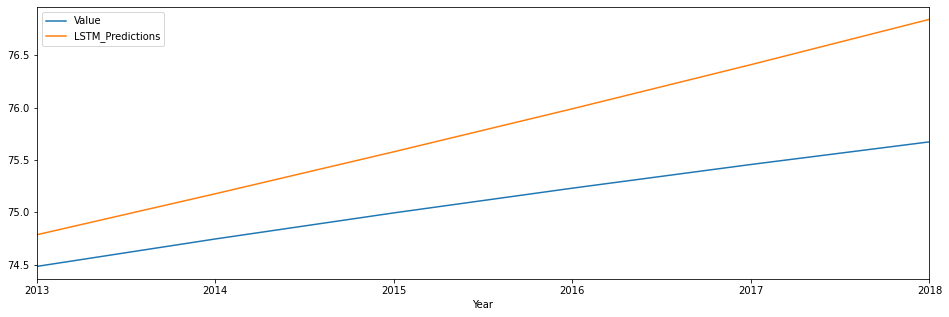

In [546]:
test_df['Value'].plot(figsize = (16,5), legend=True)
test_df['LSTM_Predictions'].plot(legend = True);

In [547]:
lstm_rmse_error = rmse(test_df['Value'], test_df["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 0.577644401495857
RMSE Error: 0.7600292109490642
Mean: 67.74491836734695


In [548]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_df)+6):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [549]:
lstm_predictions_scaled

[array([1.0376476], dtype=float32),
 array([1.0632296], dtype=float32),
 array([1.0894297], dtype=float32),
 array([1.1162608], dtype=float32),
 array([1.1437835], dtype=float32),
 array([1.1720709], dtype=float32),
 array([1.2012328], dtype=float32),
 array([1.2313851], dtype=float32),
 array([1.2626871], dtype=float32),
 array([1.2952441], dtype=float32),
 array([1.3293967], dtype=float32),
 array([1.3653687], dtype=float32)]

In [550]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [551]:
lstm_predictions

array([[74.78493306],
       [75.17628582],
       [75.5770961 ],
       [75.98755721],
       [76.40859922],
       [76.84134003],
       [77.28745924],
       [77.74872944],
       [78.22758706],
       [78.72564421],
       [79.24811109],
       [79.79841074]])

In [552]:
output2=lstm_predictions
outputs2 = pd.DataFrame(lstm_predictions[-7:])
outputs2.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
outputs2["Country"]=country_to_predict
outputs2

,0,Country
2019,76.841340,Brazil
2020,77.287459,Brazil
2021,77.748729,Brazil
2022,78.227587,Brazil
2023,78.725644,Brazil
2024,79.248111,Brazil
2025,79.798411,Brazil


In [553]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_lstm.xlsx')
writer = pandas.ExcelWriter('test_lstm.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    outputs2.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

**Prophet**

In [554]:
df = pd.read_excel('test_prophet.xlsx')
df=df[(df['Country']==country_to_predict)]
del df["Country"]
df.head()
df_pr = df.copy()
#df = df.reset_index()
df_pr.columns = ['ds','y']
df_pr.tail()


,ds,y
93,2014,74.745
94,2015,74.994
95,2016,75.230
96,2017,75.456
97,2018,75.672


In [555]:
df_pr['ds'] = pd.to_datetime(df_pr['ds'],format="%Y")
df_pr.tail()

,ds,y
93,2014-01-01,74.745
94,2015-01-01,74.994
95,2016-01-01,75.230
96,2017-01-01,75.456
97,2018-01-01,75.672


In [556]:
train_data_pr = df_pr.iloc[:len(df)-6]
test_data_pr = df_pr.iloc[len(df)-6:]

In [557]:
from fbprophet import Prophet

In [558]:
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=6,freq='YS')
prophet_pred = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [559]:
prophet_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
44,2014-01-01,19.331495,74.939105,75.002421,19.311339,19.354881,55.638281,55.638281,55.638281,55.638281,55.638281,55.638281,0.0,0.0,0.0,74.969776
45,2015-01-01,19.672151,75.256799,75.358384,19.632389,19.717275,55.630520,55.630520,55.630520,55.630520,55.630520,55.630520,0.0,0.0,0.0,75.302671
46,2016-01-01,20.012807,75.569843,75.719778,19.949490,20.085913,55.627614,55.627614,55.627614,55.627614,55.627614,55.627614,0.0,0.0,0.0,75.640420
47,2017-01-01,20.354396,75.893437,76.097177,20.261121,20.458180,55.638108,55.638108,55.638108,55.638108,55.638108,55.638108,0.0,0.0,0.0,75.992504
48,2018-01-01,20.695052,76.210576,76.473836,20.567127,20.829803,55.638281,55.638281,55.638281,55.638281,55.638281,55.638281,0.0,0.0,0.0,76.333333


In [560]:
prophet_pred = pd.DataFrame({"Year" : prophet_pred[-6:]['ds'], "Pred" : prophet_pred[-6:]["yhat"]})

In [561]:
prophet_pred = prophet_pred.set_index("Year")

In [562]:
prophet_pred.index.freq = "YS"

In [563]:
prophet_pred

,Pred
Year,
2013-01-01,74.628947
2014-01-01,74.969776
2015-01-01,75.302671
2016-01-01,75.640420
2017-01-01,75.992504
2018-01-01,76.333333


In [564]:
test_df["Prophet_Predictions"] = prophet_pred['Pred'].values
test_df

,Value,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions
Year,,,,
2013-01-01,74.483,74.483156,74.784933,74.628947
2014-01-01,74.745,74.744948,75.176286,74.969776
2015-01-01,74.994,74.994562,75.577096,75.302671
2016-01-01,75.230,75.232160,75.987557,75.640420
2017-01-01,75.456,75.457890,76.408599,75.992504
2018-01-01,75.672,75.671879,76.841340,76.333333


In [565]:
import seaborn as sns

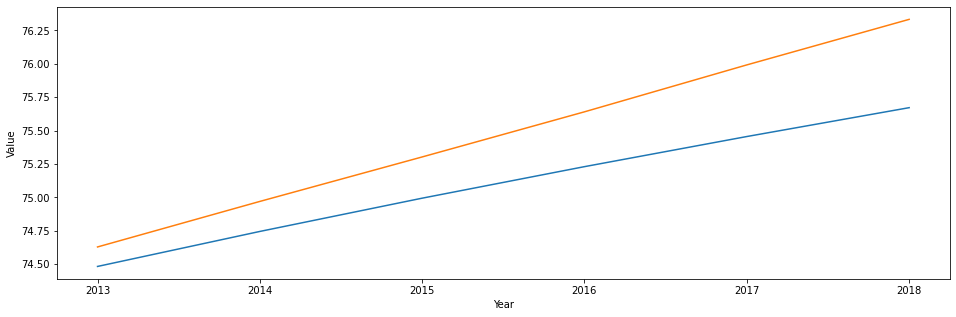

In [566]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_df.index, y=test_df["Value"])
sns.lineplot(x=test_df.index, y = test_df["Prophet_Predictions"]);

In [567]:
prophet_rmse_error = rmse(test_df['Value'], test_df["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 0.17679099611164367
RMSE Error: 0.4204652139138786
Mean: 67.74491836734695


In [568]:
future = m.make_future_dataframe(periods=13,freq = 'YS')
prophet_pred = m.predict(future)

In [569]:
#prophet_pred = pd.DataFrame({"Year" : prophet_pred[-11:]['ds'], "Pred" : prophet_pred[-11:]["yhat"]})
abc=prophet_pred[['ds', 'yhat']].tail(7)

In [570]:
abc.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
del abc['ds']
abc = abc.rename(columns={'yhat': 'Value'})
abc["Country"]=country_to_predict
abc

,Value,Country
2019,76.666228,Brazil
2020,77.003977,Brazil
2021,77.356061,Brazil
2022,77.696890,Brazil
2023,78.029785,Brazil
2024,78.367534,Brazil
2025,78.719618,Brazil


In [571]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_prophet.xlsx')
writer = pandas.ExcelWriter('test_prophet.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    abc.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

In [572]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})

Mean: 75.09666666666668


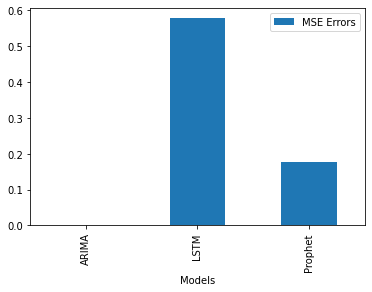

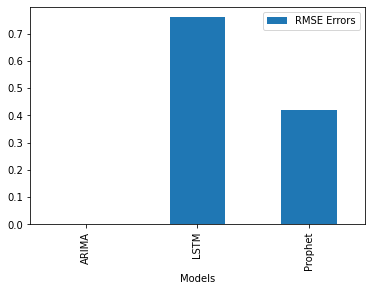

In [573]:
print(f"Mean: {test_df['Value'].mean()}")
errors
errors.plot(kind="bar",x="Models",y="MSE Errors")
errors.plot(kind="bar",x="Models",y="RMSE Errors")

In [574]:
errors["Country"]=country_to_predict
errors

,Models,RMSE Errors,MSE Errors,Country
0,ARIMA,0.001197,0.000001,Brazil
1,LSTM,0.760029,0.577644,Brazil
2,Prophet,0.420465,0.176791,Brazil


In [575]:
import pandas
from openpyxl import load_workbook

book = load_workbook('errors.xlsx')
writer = pandas.ExcelWriter('errors.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    errors.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index =False,header= False)

writer.save()

In [576]:
output3=test_df
output3["Country"]=country_to_predict
output3.reset_index()
output3.index=['2013', '2014', '2015','2016', '2017', '2018']
output3

,Value,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions,Country
2013,74.483,74.483156,74.784933,74.628947,Brazil
2014,74.745,74.744948,75.176286,74.969776,Brazil
2015,74.994,74.994562,75.577096,75.302671,Brazil
2016,75.230,75.232160,75.987557,75.640420,Brazil
2017,75.456,75.457890,76.408599,75.992504,Brazil
2018,75.672,75.671879,76.841340,76.333333,Brazil


In [577]:
import pandas
from openpyxl import load_workbook

book = load_workbook('comparison.xlsx')
writer = pandas.ExcelWriter('comparison.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    output3.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index =True,header= False)

writer.save()

<Figure size 1368x648 with 0 Axes>

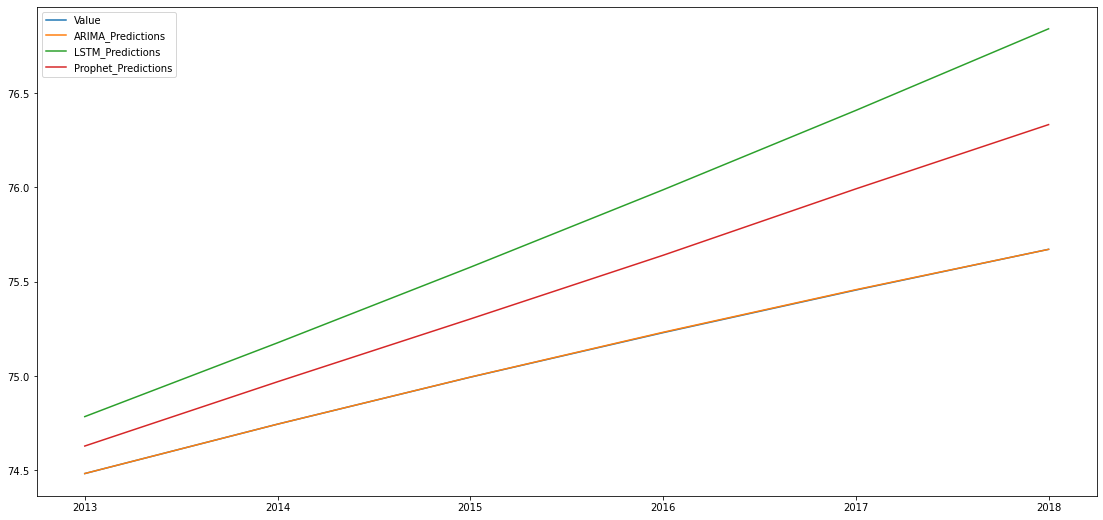

In [578]:
plt.figure(figsize=(19,9))
test_df.plot(figsize=(19,9))